In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

### Introduction of the paramaters for the optimization problem

In [2]:
#parameters of the problem
n = 10 # dimension of the problem 
d = 100 # Number of constraints
lambdad = 10

np.random.seed(43)      
X = np.random.rand(n,d)    
np.random.seed(12)   
y = np.random.rand(n)
Q = np.eye(n)
e = np.array([1 for i in range(2*d)])
p = np.dot(y,-1)
F = np.concatenate((np.transpose(X), - np.transpose(X)), axis = 0)
b = np.dot(lambdad,e)
eps = 10e-8
t = 1
Mu = [2,15,50,100, 500]


We want to apply Newton's method on the following function : 
$$
f_0(x) = \frac{1}{2}x^T Q x + p^Tx  + \phi(x)
$$ where 
$$
\phi(x) = -\sum\limits_{i = 1}^{2d}\log(\lambda - f_i^Tx)
$$
We'll deal here in this case with no equality constraint, which simplify a bit the resolution.
We have :
$$
\nabla f_0(x) = Qx + p + \sum \limits_{i = 1}^{2d} \displaystyle\frac{f_i}{\lambda - f_i^Tx}
$$
and 
$$
\nabla^2 f_0(x) = Q + \sum\limits_{i = 1}^{2d}\displaystyle \frac{f_i f_i^T}{(f_i^T x - \lambda)^2} 
$$

Computation of the hessian $\nabla^2 f_t$

In [3]:
def hess_f_t(Q,p,A,b,x,t): #evaluate the hessian of f at x
    """
    return the hessian of the objective function at x

    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        t: (int) parameter of the barrier method
        b: (array) rhs of the linear inequality, sized [2d,]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
    Returns:
        hessian of f_0(x) : (array), sized [n,n]
    """
    hess = Q*t
    for i in range(2*d):
        f_i = A[i] #ième ligne 
        mat = np.array([[f_i[i]*f_i[j] for i in range(n)] for j in range(n)])
        hess += mat/(np.dot(f_i,x) - b[i])**2
    return hess

Computation of the jacobian $\nabla f_t$

In [4]:
def grad_f_t(Q,p,A,b,x,t):
    """
    return the gradient of the objective function at x

    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        t: (int) parameter of the barrier method
        b: (array) rhs of the linear inequality, sized [2d,]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
    Returns:
        f_0(x) : (array), sized [n,]
    """
    grad = t*(np.dot(Q,x) + p)
    for i in range(2*d):
        f_i = A[i]
        grad += f_i/(b[i] - np.dot(f_i,x))
    return grad

Computation of the log-barrier function $\phi$

In [5]:
def check_feasible(A,b,x):
    for i in range(2*d):
        f_i = A[i]
        if (b[i] - np.dot(f_i,x) < 0):
            return False
    return True

In [6]:
def log_barrier(A,b,x):
    """
    computation of the log_barrier function at x, return infinity if out of the domain
    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        t: (int) parameter of the barrier method
        b: (array) rhs of the linear inequality, sized [2d, ]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
    Returns:
        phi(x) : (int)
    """
    phi = 0
    check = check_feasible(A,b,x)
    if check == False:
        return math.inf
    for i in range(2*d):
        f_i = A[i]
        phi -= np.log(b[i] - np.dot(f_i,x))
    return phi

Computation of the objective function $f_t$

In [17]:
def f_t(Q,p,A,b,x,t):
    """
    return the objective function evaluated at x
    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        t: (int) parameter of the barrier method
        b: (array) rhs of the linear inequality, sized [2d,]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
    Returns:
        f_0(x) : (int)
    """
    f = t*(1/2*np.dot(x,np.dot(Q,x)) + np.dot(p,x))
    phi = log_barrier(A,b,x)
    return f + phi

In [8]:
def f_0(Q,p,x):
    """
    return the objective function evaluated at x
    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        b: (array) rhs of the linear inequality, sized [2d,]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
    Returns:
        f_0(x) : (int)
    """
    f = (1/2*np.dot(x,np.dot(Q,x)) + np.dot(p,x))
    return f

### Classic backtracking

Implementation of the backtracking, with $\omega_1 = 10^{-4}$ and $\tau = 0.2$.

In [9]:
def backtracking(Q,p,A,b,x,t,dir):
    """
    return the right step validating Armijo's rule.

    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        t: (int) parameter of the barrier method
        b: (array) rhs of the linear inequality, sized [2d,]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
        dir: (array) the descent direction at iteration k, sized [n,]

    Returns:
        alpha : (int) the step for gradient descent according to armijo's rule
    """
    k = 0
    w = 10e-4
    tau = 0.5
    alpha = 1

    grad_f = grad_f_t(Q,p,A,b,x,t)
    x_new = x + alpha*dir
    f = f_t(Q,p,A,b,x,t)
    diff = f_t(Q,p,A,b,x_new,t) - (f + w*alpha*np.dot(dir,grad_f))
    while (diff > 0 and k < 4):
        k += 1
        alpha *= tau
        x_new = x + alpha*dir
        diff = f_t(Q,p,A,b,x_new,t) - (f + w*alpha*np.dot(dir,grad_f))
      #  print('dir = ', dir, 'x = ', x, 'alpha = ', alpha ,'diff = ', diff )
       # print('diff = ', diff )
    return alpha

### gradient-based backtracking

In [10]:
def backtracking_with_gradient(Q,p,A,b,x,t,dir):
    """
    return the right step validating Armijo's rule.

    Args : 
        x: (array) the point at which we evaluate the function, sized [n,]
        t: (int) parameter of the barrier method
        b: (array) rhs of the linear inequality, sized [2d,]
        A: (array) lhs of the linear inequality, sized [2d,n]
        Q: (array), sized [n,n]
        p: (array), sized [n,]
        dir: (array) the descent direction at iteration k, sized [n,]

    Returns:
        alpha : (int) the step for gradient descent according to armijo's rule
    """
    k = 0
    w = 10e-4
    tau = 0.05
    alpha = 1

    grad_f = grad_f_t(Q,p,A,b,x,t)
    x_new = x + alpha*dir

    grad_f_new = grad_f_t(Q,p,A,b,x_new,t)
    diff = np.linalg.norm(grad_f_new)**2 - np.linalg.norm(grad_f)**2*(1 - w*alpha)
    while (diff > 0):
        k += 1
        alpha *= tau
        x_new = x + alpha*dir 
        grad_f_new = grad_f_t(Q,p,A,b,x_new,t) #With new alpha
        diff = np.linalg.norm(grad_f_new)**2 - np.linalg.norm(grad_f)**(1 - w*alpha)
       # print('dir = ', dir, 'x = ', x, 'alpha = ', alpha ,'diff = ', diff )
    return alpha

Check whether the solution position is feasible i.e if
$$
Fx \leq b
$$
or more precisely if $\forall i \in \{1,2d\}$
$$
f_i^Tx \leq \lambda
$$
where $f_i$ is the $i^{th}$ row of F and F is defined as 
$$
F = \large \begin{pmatrix}
    X^T \\
    -X^T \\
\end{pmatrix}
$$

In [11]:
def test_symetry(M):
    for i in range(n):
        for j in range(n):
            if M[i,j] != M[j,i]:
                return False
    return True

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

x = np.array([np.random.rand() for i in range(10)])
hess = hess_f_t(Q,p,F,b,x,t)
is_pos_def(hess)

True

### Centering step

This is the crucial step where we solve the minimization problem via Newton's method for a given t

In [12]:
def centering_step(Q,p,A,b,t,v0,eps):
    """
    It computes the Newton method to solve the problem \grad f_t(x) = 0

    Args : 
        Q: (array) positive definite matrix, sized [n,n]
        p: (array), sized [n,]
        F: (array), matrix of the inequality constraint Fx <= h and appearing in the barrier function, sized [d,n]
        t: (int) parameter of the barrier method
        v0: (array) initialisation point, in the strictly feasible domain, sized [n,]
        eps: (int) accepted error/target precision

    Returns:
        The list of iterates x until convergence at precision epsilon
    """
    V = [v0]
    x = v0
    grad_f = grad_f_t(Q,p,A,b,x,t)
    hess_f = hess_f_t(Q,p,A,b,x,t)
    dir = - np.linalg.solve(hess_f, grad_f)
    criteria = np.dot(hess_f, dir)
    criteria = np.dot(dir,criteria)
    n_iter = 0

    while (criteria > 2*eps): #criteria to stop
        #alpha = backtracking_with_gradient(Q,p,A,b,x,t, dir)
        alpha = backtracking(Q,p,A,b,x,t, dir)
        x = x + alpha*dir

        #computation of derivatives
        grad_f = grad_f_t(Q,p,A,b,x,t)
        hess_f = hess_f_t(Q,p,A,b,x,t)

        #computation of criteria
        criteria = np.dot(hess_f, dir)
        criteria = np.dot(dir,criteria)

        #new direction
        dir = - np.linalg.solve(hess_f, grad_f)
        V += [x]

        n_iter += 1 #every passage in the loop is a Newton iteration
    return V, n_iter

### Barrier method

We solve here the centering problem to draw a central path in the strictly feasible domain $\mathcal{D} = \{x \in \mathbf{R}^n | Fx < \lambda e_{2d}\}$. An obvious point here is $v_0 = O_{n}$, since $\lambda > 0$

In [13]:
def barr_method(Q,p,A,b,v0,eps) :
    X = [[] for i in range(5)]
    N_iter = [[] for i in range(len(Mu))]
    for i in range(len(Mu)):
        t = 1
        x = v0
        while (2*d/t > eps):
            V, n_iter = centering_step(Q,p,A,b,t,x,eps) #n_iter is the number of column of V
            t *= Mu[i]
            x = V[-1] #Principle of the central path : we start from the last solution computed previously
            N_iter[i] += [n_iter]
            X[i] += [x] #sequence of iteration for this t*mu
    return X, N_iter
v0 = np.zeros((n))
X, N_iter = barr_method(Q,p,F,b,v0,eps)

In [14]:
def sum(L): #Sum with the left neighbour
    N = np.zeros(len(L))
    N[0] = L[0]
    for i in range(1,len(L)):
        N[i] = N[i - 1] + L[i]
    return N

## Results

### For classical backtracking and $\epsilon = 10^{-8}$

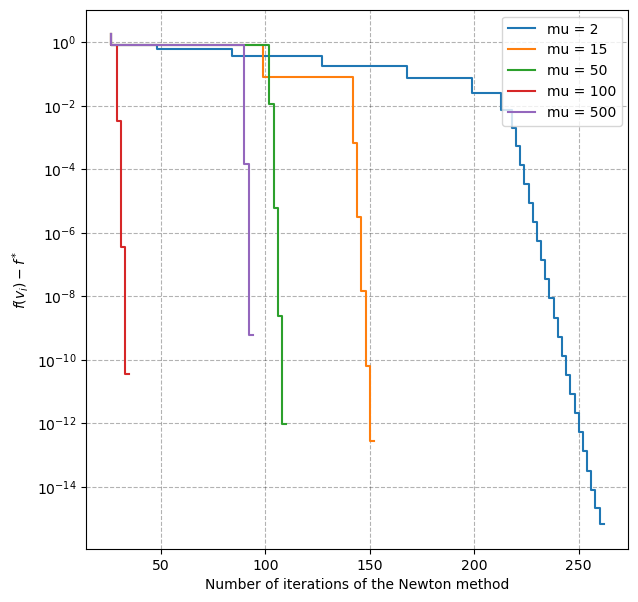

In [18]:
for i in range(len(Mu)):
    plt.figure(num=1,figsize=(7,7)) 
    n_iter = N_iter[i]
    Newton_iter = sum(n_iter) #abscisse
    V = X[i] #give me the sequence for this mu
    f = [f_0(Q,p,V[j]) for j in range(len(V))] #I evaluate at every sequence the objective function
    gap = [f_0(Q,p,[0 for i in range(n)]) - f[-1]] + [p - f[-1] for p in f[:-1]] #This is the gap at every iteration
    plt.step(Newton_iter, gap, label='mu = '+str(Mu[i]))
    plt.figure(1)
    plt.legend(loc = 'upper right')
    plt.semilogy()
    plt.xlabel('Number of iterations of the Newton method')
    plt.ylabel('$f(v_i)-f^*$')
    plt.rc('grid', linestyle="--", color='black',alpha = 0.3)
    plt.grid(True)

### With gradient-based backtracking and $\epsilon = 10^{-8}$

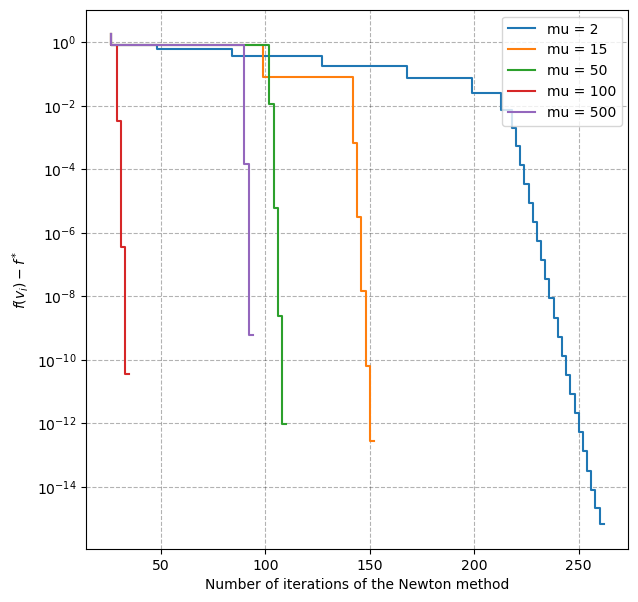

In [19]:
for i in range(len(Mu)):
    plt.figure(num=1,figsize=(7,7)) 
    n_iter = N_iter[i]
    Newton_iter = sum(n_iter) #abscisse
    V = X[i] #give me the sequence for this mu
    f = [f_0(Q,p,V[j]) for j in range(len(V))] #I evaluate at every sequence the objective function
    gap = [f_0(Q,p,[0 for i in range(n)]) - f[-1]] + [p - f[-1] for p in f[:-1]] #This is the gap at every iteration
    plt.step(Newton_iter, gap, label='mu = '+str(Mu[i]))
    plt.figure(1)
    plt.legend(loc = 'upper right')
    plt.semilogy()
    plt.xlabel('Number of iterations of the Newton method')
    plt.ylabel('$f(v_i)-f^*$')
    plt.rc('grid', linestyle="--", color='black',alpha = 0.3)
    plt.grid(True)